# Homework Week 05

Material from Chapters 8 and 9 (Conditional Manatees and Markov Chain Monte Carlo)

## Data and preliminaries

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn import preprocessing

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)  #suppress Arviz warnings

In [2]:
d = pd.read_csv("Data/Wines2012.csv",
               sep=";")
d.head()

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0


### Rescale score

I originally rescaled on the interval [0,1] but Richard standardized.  So for compatibility, I have standardized.

In [94]:
# d["score_s"] = (d["score"] - d["score"].min())/(d["score"].max() - d["score"].min()) # rescale on interval [0,1]
d["score_s"] = (d["score"] - d["score"].mean())/d["score"].std()

### Create index variables for judge and wine

First, change data type to category

In [95]:
d["judge"] = d["judge"].astype("category")
d["wine"] = d["wine"].astype("category")

In [96]:
dict(enumerate(d["judge"].cat.categories))

{0: 'Daniele Meulder',
 1: 'Francis Schott',
 2: 'Jamal Rayyis',
 3: 'Jean-M Cardebat',
 4: 'John Foy',
 5: 'Linda Murphy',
 6: 'Olivier Gergaud',
 7: 'Robert Hodgson',
 8: 'Tyler Colman'}

In [97]:
n_judge = len(d["judge"].cat.categories)
n_wine = len(d["wine"].cat.categories)
n_judge, n_wine

(9, 20)

Then, create new columns creating just the index codes

In [98]:
d["judge_idx"] = d["judge"].cat.codes
d["wine_idx"] = d["wine"].cat.codes

In [101]:
d.head()

,judge,flight,wine,score,wine.amer,judge.amer,score_s,judge_idx,wine_idx,flight_idx
0,Jean-M Cardebat,white,A1,10.0,1,0,-1.576604,3,0,1
1,Jean-M Cardebat,white,B1,13.0,1,0,-0.450458,3,2,1
2,Jean-M Cardebat,white,C1,14.0,0,0,-0.075076,3,4,1
3,Jean-M Cardebat,white,D1,15.0,0,0,0.300306,3,6,1
4,Jean-M Cardebat,white,E1,8.0,1,0,-2.327368,3,8,1


## Question 1

> In this first problem, consider only variation among judges and wines.
Construct index variables of judge and wine and then use these index variables
to construct a linear regression model. Justify your priors. You should
end up with 9 judge parameters and 20 wine parameters.

This is an intercept-only model using index variables:

In [102]:
with pm.Model() as q1_m1:
    a_wine = pm.Normal("a_wine", 0, 0.5, shape=n_wine)
    a_judge = pm.Normal("a_judge", 0, 0.5, shape=n_judge)
    mu = a_judge[d["judge_idx"]] + a_wine[d["wine_idx"]]
    sigma = pm.Exponential("sigma", 1)
    score = pm.Normal("score", mu, sigma, observed=d["score_s"])
    q1_m1_trace = pm.sample(tune=1000, draws=1000, )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a_judge, a_wine]


Sampling 2 chains for 2_000 tune and 20_000 draw iterations (4_000 + 40_000 draws total) took 42 seconds.


In [103]:
with q1_m1:
    q1_m1_res = az.summary(q1_m1_trace, round_to=2)
q1_m1_res

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_wine[0],0.12,0.26,-0.36,0.62,0.0,0.0,62650.02,23525.17,62642.12,30007.49,1.0
a_wine[1],0.09,0.26,-0.40,0.57,0.0,0.0,57517.96,20242.41,57483.86,30693.29,1.0
a_wine[2],0.23,0.26,-0.23,0.74,0.0,0.0,63195.54,32218.78,63206.46,30340.14,1.0
a_wine[3],0.47,0.26,-0.01,0.95,0.0,0.0,66269.48,50135.05,66240.60,31008.24,1.0
a_wine[4],-0.10,0.26,-0.60,0.37,0.0,0.0,62116.86,21841.91,62102.14,31204.67,1.0
a_wine[5],-0.31,0.26,-0.80,0.17,0.0,0.0,60759.71,36258.34,60766.99,30351.09,1.0
a_wine[6],0.24,0.26,-0.23,0.73,0.0,0.0,60916.78,32535.34,60943.51,31159.55,1.0
a_wine[7],0.23,0.26,-0.25,0.71,0.0,0.0,61793.13,32598.36,61804.30,31156.33,1.0
a_wine[8],0.07,0.26,-0.42,0.56,0.0,0.0,60981.34,20277.25,60985.11,30423.50,1.0
a_wine[9],0.10,0.26,-0.38,0.57,0.0,0.0,58714.62,23056.84,58722.67,31583.70,1.0


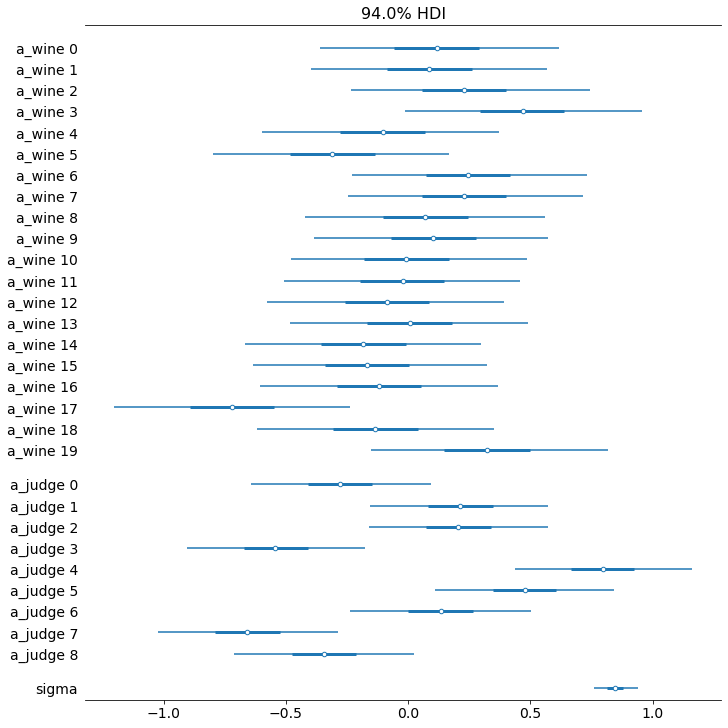

In [108]:
az.plot_forest(q1_m1_trace, figsize=(10,10), combined=True );

### Intpretation

Some wines are higher rated than others&mdash;only one is really bad.  Some judged appear to score higher than others.

In [15]:
d.loc[d["judge_idx"] == 8, "score_s"].mean()

0.6743589743589743

Looking at judge means, they are consistent (ordinally) with mean scores.

In [18]:
d.groupby("judge_idx")["score_s"].mean()

judge_idx
0    0.684615
1    0.761538
2    0.760256
3    0.643590
4    0.852564
5    0.802564
6    0.748718
7    0.625641
8    0.674359
Name: score_s, dtype: float64

## Question 2

>Use indicator or index variables to model the influence of these features on
the scores. Omit the individual judge and wine index variables from Problem 1. Do not include interaction effects yet. Again use ulam, justify your priors,
and be sure to check the chains. What do you conclude about the differences
among the wines and judges? Try to relate the results to the inferences in
Problem 1.

### Create additional index variables

In [22]:
d["flight"] = d["flight"].astype("category")
n_flight = len(d["flight"].cat.categories)
dict(enumerate(d["flight"].cat.categories))

{0: 'red', 1: 'white'}

In [21]:
d["flight_idx"] = d["flight"].cat.codes

### Create model

Again, I set this up with index variables in an intercept-only model.  Richard also uses a dummy variable model.

In [105]:
with pm.Model() as q2_m1:
    a_flight = pm.Normal("a_flight", 0, 0.2, shape=n_flight)
    a_wineA = pm.Normal("a_wineA", 0, 0.2, shape=2)
    a_judgeA = pm.Normal("a_judgeA", 0, 0.2, shape=2)
    mu = a_flight[d["flight_idx"]] + a_wineA[d["wine.amer"]] + a_judgeA[d["judge.amer"]]
    sigma = pm.Exponential("sigma", 1)
    score = pm.Normal("score", mu, sigma, observed=d["score_s"])
    q2_m1_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a_judgeA, a_wineA, a_flight]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


In [106]:
with q2_m1:
    q2_m1_res = az.summary(q2_m1_trace, round_to=2)
q2_m1_res

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_flight[0],0.00,0.14,-0.26,0.26,0.0,0.0,1504.56,1030.65,1513.23,1183.52,1.0
a_flight[1],0.00,0.14,-0.27,0.26,0.0,0.0,1537.22,1253.43,1540.26,1431.62,1.0
a_wineA[0],0.07,0.14,-0.19,0.32,0.0,0.0,1614.28,1460.51,1621.02,1549.72,1.0
a_wineA[1],-0.08,0.13,-0.34,0.17,0.0,0.0,1610.46,1241.09,1609.23,1312.08,1.0
a_judgeA[0],-0.09,0.14,-0.35,0.15,0.0,0.0,1270.13,980.01,1259.08,1231.71,1.0
a_judgeA[1],0.10,0.14,-0.15,0.36,0.0,0.0,1408.37,1230.13,1404.84,1266.92,1.0
sigma,1.00,0.05,0.90,1.10,0.0,0.0,2073.33,2067.26,2073.41,1136.27,1.0


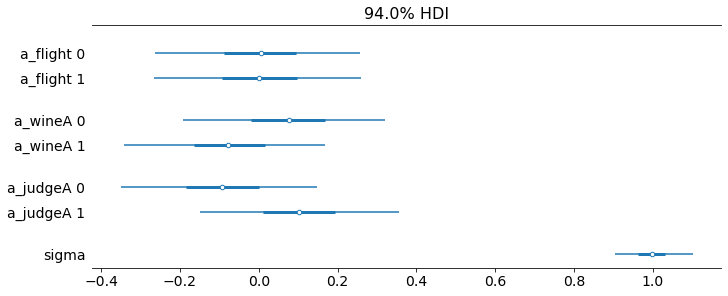

In [112]:
az.plot_forest(q2_m1_trace, figsize=(10,4), combined=True );

### Interpretation

Hard to make sense of this. American wines are slightly worse and American judges rate slightly higher on average.

## Question 3

>Now consider two-way interactions among the three features. You should
end up with three different interaction terms in your model. These will be
easier to build, if you use indicator variables. 

>Explain what each interaction means.
Be sure to interpret the model’s predictions on the outcome scale (mu, the
expected score), not on the scale of individual parameters. You can use link
to help with this, or just use your knowledge of the linear model instead.
What do you conclude about the features and the scores? Can you relate
the results of your model(s) to the individual judge and wine inferences from
Problem 1?

In [53]:
flights = d["flight_idx"].values
wine_amer = d["wine.amer"].values
judge_amer = d["judge.amer"].values

In [113]:
with pm.Model() as q3_m1:
    a_flight = pm.Normal("a_flight", 0, 0.2, shape=n_flight)
    a_wineA = pm.Normal("a_wineA", 0, 0.2, shape=2)
    a_judgeA = pm.Normal("a_judgeA", 0, 0.2, shape=2)
    
    #interactions
    a_fj = pm.Normal("a_fj", 0, 0.2, shape=(n_flight,2))
    a_fw = pm.Normal("a_fw", 0, 0.2, shape=(n_flight,2))
    a_jw = pm.Normal("a_jw", 0, 0.2, shape=(2,2))
    
    #model
    mu = a_flight[d["flight_idx"]] + a_wineA[d["wine.amer"]] + a_judgeA[d["judge.amer"]] + a_fj[d["flight_idx"], d["judge.amer"]]  + a_fw[d["flight_idx"], d["wine.amer"]] + a_jw[d["judge.amer"], d["wine.amer"]]
    sigma = pm.Exponential("sigma", 1)  
    score = pm.Normal("score", mu, sigma, observed=d["score_s"])
    q3_m1_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a_jw, a_fw, a_fj, a_judgeA, a_wineA, a_flight]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


In [114]:
with q3_m1:
    q3_m1_res = az.summary(q3_m1_trace, round_to=2)
q3_m1_res

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_flight[0],0.01,0.16,-0.29,0.30,0.0,0.0,2366.87,1008.22,2375.82,1633.89,1.00
a_flight[1],-0.00,0.16,-0.29,0.32,0.0,0.0,2436.72,861.65,2465.88,1239.67,1.00
a_wineA[0],0.04,0.17,-0.30,0.34,0.0,0.0,2545.67,1193.65,2543.72,1638.22,1.00
a_wineA[1],-0.04,0.16,-0.33,0.26,0.0,0.0,2022.63,1021.90,2028.03,1527.37,1.00
a_judgeA[0],-0.06,0.16,-0.36,0.27,0.0,0.0,2863.29,1267.43,2870.58,1514.59,1.00
a_judgeA[1],0.06,0.16,-0.24,0.36,0.0,0.0,2388.69,1119.56,2380.66,1550.48,1.00
"a_fj[0,0]",-0.04,0.17,-0.36,0.28,0.0,0.0,2394.63,1191.91,2393.04,1758.22,1.00
"a_fj[0,1]",0.03,0.17,-0.29,0.33,0.0,0.0,2783.28,1080.89,2796.14,1421.56,1.00
"a_fj[1,0]",-0.03,0.17,-0.36,0.28,0.0,0.0,2477.34,1321.80,2480.65,1601.63,1.00
"a_fj[1,1]",0.02,0.16,-0.30,0.31,0.0,0.0,2673.97,1078.09,2673.41,1611.15,1.00


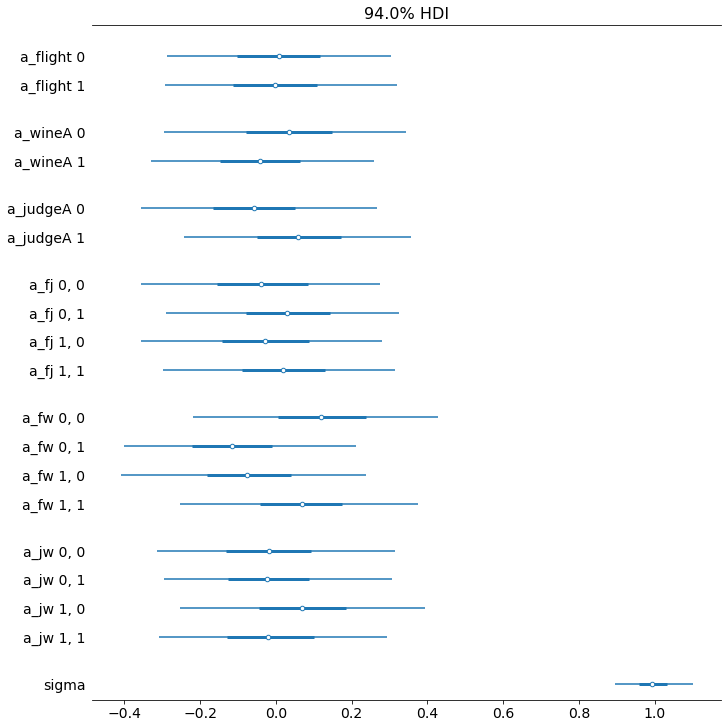

In [115]:
az.plot_forest(q3_m1_trace, figsize=(10,10), combined=True );

### Interpretation

Yikes, hard to interpret.  Basically, I see no interaction between American wines and American judges.